In [1]:
import json
import urllib

import httpx
import time
import requests
import textwrap

import pandas as pd
import numpy as np
import sys

from api_key import WOS_API_KEY

from requests import Session

from pprint import pprint

import sys 
import re
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sentence_transformers import SentenceTransformer
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from bertopic.backend import WordDocEmbedder

import gensim.downloader as api
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import WordEmbeddingSimilarityIndex
from bertopic import BERTopic

from re import sub
from multiprocessing import cpu_count

from gensim.similarities import SparseTermSimilarityMatrix
from gensim.similarities import SoftCosineSimilarity

from xgboost import XGBClassifier
import argparse
from keybert import KeyBERT
from sklearn.metrics.pairwise import cosine_similarity

from autocorrect import Speller
import tldextract

from itertools import combinations
from nltk import skipgrams
import umap

import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib as mpl
from pylab import rcParams
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_theme(style='white')
#% matplotlib inline
from datetime import datetime

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
from plotly.subplots import make_subplots
from plotly.offline import iplot

from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger
from bertopic.vectorizers import ClassTfidfTransformer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
nltk.download('maxent_ne_chunker')
nltk.download('words')

import spacy
nlp = spacy.load('en_core_web_sm')

from gensim.models import word2vec
import pickle
import gzip
import argparse
import torch
from transformers import BertTokenizer, BertModel
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import PartOfSpeech

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/aditidutta/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
'''
# Sending the initial request
SEARCH_QUERY = 'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*) OR (gender NEAR/3 stereotype) OR (gender NEAR/3 violence))) AND PY=2012-2022'
HEADERS = {'X-APIkey': WOS_API_KEY}
DATABASE_ID = 'WOS' 

test_request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                            f'count=0&firstRecord=1', headers=HEADERS)
data = test_request.json()

total_documents_found = data['QueryResult']['RecordsFound']
requests_required = ((total_documents_found - 1) // 100 ) + 1
for i in range(0, requests_required):
    request = requests.get(f'https://api.clarivate.com/api/wos?databaseId=WOS&usrQuery={SEARCH_QUERY}&'
                                      f'count=100&firstRecord={i}01', headers=HEADERS)
    data = request.json()
    results = data['Data']['Records']['records']['REC']
    with open(f'data/collected/basic_search/searches_{i}.json', "w") as outfile:
        json.dump(results, outfile)

    time.sleep(5)
'''

'\n# Sending the initial request\nSEARCH_QUERY = \'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*) OR (gender NEAR/3 stereotype) OR (gender NEAR/3 violence))) AND PY=2012-2022\'\nHEADERS = {\'X-APIkey\': WOS_API_KEY}\nDATABASE_ID = \'WOS\' \n\ntest_request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&\'\n                            f\'count=0&firstRecord=1\', headers=HEADERS)\ndata = test_request.json()\n\ntotal_documents_found = data[\'QueryResult\'][\'RecordsFound\']\nrequests_required = ((total_documents_found - 1) // 100 ) + 1\nfor i in range(0, requests_required):\n    request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId=WOS&usrQuery={SEARCH_QUERY}&\'\n                                      f\'count=100&firstRecord={i}01\', headers=HEADERS)\n    data = request.json()\n    results = data[\'Data\'][\'Records\'][\'records\'][\'REC\']\n    with open(f\'data/collected/basic_search/searches_{i}.json\', "w") as 

In [3]:
'''
# Sending the initial request
SEARCH_QUERY = 'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*) OR (gender NEAR/3 stereoty*) OR (gender NEAR/3 violence)) NEAR/20 (detect* OR identif* OR predict* OR classif*)) AND PY=2012-2022'
HEADERS = {'X-APIkey': WOS_API_KEY}
DATABASE_ID = 'WOS' 

test_request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                            f'count=0&firstRecord=1', headers=HEADERS)
data = test_request.json()

total_documents_found = data['QueryResult']['RecordsFound']
requests_required = ((total_documents_found - 1) // 100 ) + 1
for i in range(0, requests_required):
    request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                                      f'count=100&firstRecord={i}01', headers=HEADERS)
    data = request.json()
    results = data['Data']['Records']['records']['REC']
    with open(f'data/collected/adv_search_2/searches_{i}.json', "w") as outfile:
        json.dump(results, outfile)

    time.sleep(2)
'''

'\n# Sending the initial request\nSEARCH_QUERY = \'TS=((misogyn* OR sexis* OR (gender NEAR/3 discrim*) OR (gender NEAR/3 stereoty*) OR (gender NEAR/3 violence)) NEAR/20 (detect* OR identif* OR predict* OR classif*)) AND PY=2012-2022\'\nHEADERS = {\'X-APIkey\': WOS_API_KEY}\nDATABASE_ID = \'WOS\' \n\ntest_request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&\'\n                            f\'count=0&firstRecord=1\', headers=HEADERS)\ndata = test_request.json()\n\ntotal_documents_found = data[\'QueryResult\'][\'RecordsFound\']\nrequests_required = ((total_documents_found - 1) // 100 ) + 1\nfor i in range(0, requests_required):\n    request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&\'\n                                      f\'count=100&firstRecord={i}01\', headers=HEADERS)\n    data = request.json()\n    results = data[\'Data\'][\'Records\'][\'records\'][\'REC\']\n    with op

In [4]:
'''
# Sending the initial request
SEARCH_QUERY = 'TS=((misogyn* OR sexis* OR (gender NEAR/10 discrim*) OR (gender NEAR/10 stereoty*) OR (gender NEAR/10 violence) OR (gender NEAR/10 based)) NEAR/200 (detect* OR identif* OR predict* OR classif*)) AND WC=("Computer Science" OR "Artificial Intelligence" OR "Information Systems" OR "Theory %26 Methods" OR "Engineering" OR "Electrical %26 Electronic" OR "Telecommunications" OR "Software Engineering" OR "Green %26 Sustainable Science %26 Technology" OR "Scientific Disciplines" OR "Automation %26 Control Systems" OR "Cybernetics" OR "Physics" OR "Mathematical" OR "Mathematics" OR "Mathematical Methods") AND PY=2012-2022'
HEADERS = {'X-APIkey': WOS_API_KEY}
DATABASE_ID = 'WOS' 

test_request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                            f'count=0&firstRecord=1', headers=HEADERS)
data = test_request.json()

total_documents_found = data['QueryResult']['RecordsFound']
requests_required = ((total_documents_found - 1) // 100 ) + 1
for i in range(0, requests_required):
    request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                                      f'count=100&firstRecord={i}01', headers=HEADERS)
    data = request.json()
    results = data['Data']['Records']['records']['REC']
    with open(f'data/collected/adv_search_3/searches_{i}.json', "w") as outfile:
        json.dump(results, outfile)

    time.sleep(2)
'''

'\n# Sending the initial request\nSEARCH_QUERY = \'TS=((misogyn* OR sexis* OR (gender NEAR/10 discrim*) OR (gender NEAR/10 stereoty*) OR (gender NEAR/10 violence) OR (gender NEAR/10 based)) NEAR/200 (detect* OR identif* OR predict* OR classif*)) AND WC=("Computer Science" OR "Artificial Intelligence" OR "Information Systems" OR "Theory %26 Methods" OR "Engineering" OR "Electrical %26 Electronic" OR "Telecommunications" OR "Software Engineering" OR "Green %26 Sustainable Science %26 Technology" OR "Scientific Disciplines" OR "Automation %26 Control Systems" OR "Cybernetics" OR "Physics" OR "Mathematical" OR "Mathematics" OR "Mathematical Methods") AND PY=2012-2022\'\nHEADERS = {\'X-APIkey\': WOS_API_KEY}\nDATABASE_ID = \'WOS\' \n\ntest_request = requests.get(f\'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&\'\n                            f\'count=0&firstRecord=1\', headers=HEADERS)\ndata = test_request.json()\n\ntotal_documents_found = data[\'QueryRe

In [7]:
'''
# Sending the initial request
SEARCH_QUERY = 'TS=((misogyn* OR sexis* OR (gender NEAR/10 discrim*) OR (gender NEAR/10 stereoty*) OR (gender NEAR/10 violence) OR (gender NEAR/10 based)) NEAR/200 (detect* OR identif* OR predict* OR classif*)) AND WC=("Interdisciplinary" OR "Multidisciplinary" OR "Multidisciplinary Sciences" OR "Behavioral Sciences" OR "Interdisciplinary Applications") AND PY=2012-2022'
HEADERS = {'X-APIkey': WOS_API_KEY}
DATABASE_ID = 'WOS' 

test_request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                            f'count=0&firstRecord=1', headers=HEADERS)
data = test_request.json()

total_documents_found = data['QueryResult']['RecordsFound']
requests_required = ((total_documents_found - 1) // 100 ) + 1
for i in range(0, requests_required):
    request = requests.get(f'https://api.clarivate.com/api/wos?databaseId={DATABASE_ID}&usrQuery={SEARCH_QUERY}&'
                                      f'count=100&firstRecord={i}01', headers=HEADERS)
    data = request.json()
    results = data['Data']['Records']['records']['REC']
    with open(f'data/collected/adv_search_4/searches_{i}.json', "w") as outfile:
        json.dump(results, outfile)

    time.sleep(2)
'''

In [8]:
files= []

# For the above search query
string1 = 'data/collected/basic_search/searches_' 
string2 = '.json'

for i in range(0, 223):  
    files.append(string1 + str(i) + string2)


string3 = 'data/collected/adv_search/searches_adv_' 

for i in range(0, 5):  
    files.append(string3 + str(i) + string2)


string4 = 'data/collected/adv_search_2/searches_' 

for i in range(0, 19):  
    files.append(string4 + str(i) + string2)

string5 = 'data/collected/adv_search_3/searches_' 

for i in range(0, 17):  
    files.append(string5 + str(i) + string2)

string6 = 'data/collected/adv_search_4/searches_' 

for i in range(0, 19):  
    files.append(string6 + str(i) + string2)


In [9]:
data = pd.DataFrame()

for lst in files:
    with open(lst, 'r') as f:
        data_temp = json.load(f)
    data_temp = pd.json_normalize(data_temp)
    data = pd.concat([data, data_temp], axis=0)  

data = data.reset_index(drop=True)

In [10]:
data

UID                                    r_id_disclaimer  \
0      WOS:001024863300006  ResearcherID data provided by Clarivate Analytics   
1      WOS:001024100000002  ResearcherID data provided by Clarivate Analytics   
2      WOS:001014734700006  ResearcherID data provided by Clarivate Analytics   
3      WOS:001021623900035  ResearcherID data provided by Clarivate Analytics   
4      WOS:001022758800024  ResearcherID data provided by Clarivate Analytics   
...                    ...                                                ...   
28000  WOS:000327693800007  ResearcherID data provided by Clarivate Analytics   
28001  WOS:000209026700004  ResearcherID data provided by Clarivate Analytics   
28002  WOS:000298184700003  ResearcherID data provided by Clarivate Analytics   
28003  WOS:000297392700012  ResearcherID data provided by Clarivate Analytics   
28004  WOS:000301532000011  ResearcherID data provided by Clarivate Analytics   

      static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                                   OCT 2022                               23   
1                               JAN-MAR 2022                                1   
2                                       2022                               24   
3                                       2022                               51   
4                                       2022                               28   
...                                      ...                              ...   
28000                                   2012                             23.0   
28001                                   2012                             29.0   
28002                               JAN 2012                            639.0   
28003                               JAN 2012                             28.0   
28004                                   2012                             24.0   

      static_data.summary.pub_info.journal_oas_gold  \
0                                                 N   
1                                                 N   
2                                                 N   
3                                                 Y   
4                                                 Y   
...                                             ...   
28000                                             N   
28001                                             N   
28002                                             N   
28003                                             N   
28004                                             N   

       static_data.summary.pub_info.pubyear  \
0                                      2022   
1                                      2022   
2                                      2022   
3                                      2022   
4                                      2022   
...                                     ...   
28000                                  2012   
28001                                  2012   
28002                                  2012   
28003                                  2012   
28004                                  2012   

      static_data.summary.pub_info.issue  \
0                                      5   
1                                     57   
2                                      2   
3                                    NaN   
4                                    NaN   
...                                  ...   
28000                                  7   
28001                                  3   
28002                                NaN   
28003                                  1   
28004                                  2   

      static_data.summary.pub_info.sortdate  \
0                                2022-10-01   
1                                2022-01-01   
2                                2022-01-01   
3                                2022-01-01   
4                                2022-01-01   
...                                     

In [11]:
cols = data.columns.to_list()

with open(r'list_columns.txt', 'w') as fp:
    fp.write('\n'.join(cols))

In [12]:
data['index'] = data.index
data.columns

Index(['UID', 'r_id_disclaimer', 'static_data.summary.pub_info.coverdate',
       'static_data.summary.pub_info.vol',
       'static_data.summary.pub_info.journal_oas_gold',
       'static_data.summary.pub_info.pubyear',
       'static_data.summary.pub_info.issue',
       'static_data.summary.pub_info.sortdate',
       'static_data.summary.pub_info.has_abstract',
       'static_data.summary.pub_info.pubmonth',
       ...
       'static_data.fullrecord_metadata.addresses.address_name.names.name.suffix',
       'static_data.fullrecord_metadata.related_records.record.uid',
       'static_data.fullrecord_metadata.related_records.record.titles.title.type',
       'static_data.fullrecord_metadata.related_records.record.titles.title.content',
       'static_data.fullrecord_metadata.related_records.record.type',
       'static_data.fullrecord_metadata.fund_ack.grants.grant.grant_source',
       'static_data.item.book_desc.bk_ordering',
       'static_data.fullrecord_metadata.normalized_languag

In [13]:
data['static_data.summary.pub_info.pubtype'].unique()

array(['Journal', 'Book', 'Book in series', 'Books in series', 'Books'],
      dtype=object)

In [14]:
data['static_data.summary.pub_info.pubtype'] = data['static_data.summary.pub_info.pubtype'].replace({'Book in series': 'Book',
                                                                            'Books in series': 'Book', 'Books': 'Book'})
data['static_data.summary.pub_info.pubtype'].unique()

array(['Journal', 'Book'], dtype=object)

In [15]:
titles_df = pd.json_normalize(data['static_data.summary.titles.title'])
titles_df.describe()

0  \
count                                        28005   
unique                                        6991   
top     {'type': 'source', 'content': 'SEX ROLES'}   
freq                                           459   

                                                        1  \
count                                               28005   
unique                                               6718   
top     {'type': 'source_abbrev', 'content': 'SEX ROLES'}   
freq                                                  459   

                                                     2  \
count                                            27027   
unique                                            6002   
top     {'type': 'abbrev_iso', 'content': 'Sex Roles'}   
freq                                               459   

                                                    3  \
count                                           27010   
unique                                           5989   
top     {'type': 'abbrev_11', 'content': 'SEX ROLES'}   
freq                                              459   

                                                    4  \
count                                           27010   
unique                                           6003   
top     {'type': 'abbrev_29', 'content': 'SEX ROLES'}   
freq                                              459   

                                                        5  \
count                                               27000   
unique                                              23470   
top     {'type': 'abbrev_29', 'content': 'COL PSICOL L...   
freq                                                   39   

                                                        6  \
count                                                1256   
unique                                                333   
top     {'translated': 'N', 'type': 'book_series', 'co...   
freq                                                  107   

                                                        7  
count                                                  93  
unique                                                 29  
top     {'translated': 'N', 'type': 'book_series', 'co...  
freq                                                   39

In [16]:
# Source of the title
titles_0_df = pd.json_normalize(titles_df[0])
titles_0_df['index'] = titles_0_df.index
titles_0_df = titles_0_df.rename(columns={'content': 'source_name'})
titles_0_df

type                                        source_name  index
0      source                            PAIN MANAGEMENT NURSING      0
1      source                                             ATENAS      1
2      source                                  AULA DE ENCUENTRO      2
3      source              ANALES DE LITERATURA HISPANOAMERICANA      3
4      source                       BRITISH AND AMERICAN STUDIES      4
...       ...                                                ...    ...
28000  source                              PSYCHOLOGICAL SCIENCE  28000
28001  source            IRISH JOURNAL OF PSYCHOLOGICAL MEDICINE  28001
28002  source  ANNALS OF THE AMERICAN ACADEMY OF POLITICAL AN...  28002
28003  source                        COMPUTERS IN HUMAN BEHAVIOR  28003
28004  source  AIDS CARE-PSYCHOLOGICAL AND SOCIO-MEDICAL ASPE...  28004

[28005 rows x 3 columns]

In [17]:
# Title of the content
titles_5_df = pd.json_normalize(titles_df[5])
titles_5_df['index'] = titles_5_df.index
titles_5_df = titles_5_df.rename(columns={'content': 'title'})
titles_5_df

type                                              title  index
0      item  The Impact of Sexism and Gender Stereotypes on...      0
1      item  Afro-descendants, education and communication:...      1
2      item  MICROMACHISMO IN UNIVERSITY DEGREES: A PENDING...      2
3      item  Of beauty and misogyny. Shaves in medieval, go...      3
4      item  A JOURNEY THROUGH THE FEMALE GAZE: MEDIA AND A...      4
...     ...                                                ...    ...
28000  item  Temporal Distance and Discrimination: An Audit...  28000
28001  item  A Qualitative Study of Gender-Based Pathways t...  28001
28002  item  Managing Ambivalent Prejudices: Smart-but-Cold...  28002
28003  item  Make new friends or keep the old: Gender and p...  28003
28004  item  HIV-related risk behaviors among kathoey (male...  28004

[28005 rows x 3 columns]

In [18]:
titles_0_df['source_name'].isna().sum(), titles_5_df['title'].isna().sum() # a lot of titles do not exist

(0, 1005)

In [19]:
data = data.merge(titles_0_df, on='index')
data = data.merge(titles_5_df, on='index')
data = data.drop(columns=['type_x', 'type_y'])
data

UID                                    r_id_disclaimer  \
0      WOS:001024863300006  ResearcherID data provided by Clarivate Analytics   
1      WOS:001024100000002  ResearcherID data provided by Clarivate Analytics   
2      WOS:001014734700006  ResearcherID data provided by Clarivate Analytics   
3      WOS:001021623900035  ResearcherID data provided by Clarivate Analytics   
4      WOS:001022758800024  ResearcherID data provided by Clarivate Analytics   
...                    ...                                                ...   
28000  WOS:000327693800007  ResearcherID data provided by Clarivate Analytics   
28001  WOS:000209026700004  ResearcherID data provided by Clarivate Analytics   
28002  WOS:000298184700003  ResearcherID data provided by Clarivate Analytics   
28003  WOS:000297392700012  ResearcherID data provided by Clarivate Analytics   
28004  WOS:000301532000011  ResearcherID data provided by Clarivate Analytics   

      static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                                   OCT 2022                               23   
1                               JAN-MAR 2022                                1   
2                                       2022                               24   
3                                       2022                               51   
4                                       2022                               28   
...                                      ...                              ...   
28000                                   2012                             23.0   
28001                                   2012                             29.0   
28002                               JAN 2012                            639.0   
28003                               JAN 2012                             28.0   
28004                                   2012                             24.0   

      static_data.summary.pub_info.journal_oas_gold  \
0                                                 N   
1                                                 N   
2                                                 N   
3                                                 Y   
4                                                 Y   
...                                             ...   
28000                                             N   
28001                                             N   
28002                                             N   
28003                                             N   
28004                                             N   

       static_data.summary.pub_info.pubyear  \
0                                      2022   
1                                      2022   
2                                      2022   
3                                      2022   
4                                      2022   
...                                     ...   
28000                                  2012   
28001                                  2012   
28002                                  2012   
28003                                  2012   
28004                                  2012   

      static_data.summary.pub_info.issue  \
0                                      5   
1                                     57   
2                                      2   
3                                    NaN   
4                                    NaN   
...                                  ...   
28000                                  7   
28001                                  3   
28002                                NaN   
28003                                  1   
28004                                  2   

      static_data.summary.pub_info.sortdate  \
0                                2022-10-01   
1                                2022-01-01   
2                                2022-01-01   
3                                2022-01-01   
4                                2022-01-01   
...                                     

In [20]:
data = data[~data['title'].isna()]
data

UID                                    r_id_disclaimer  \
0      WOS:001024863300006  ResearcherID data provided by Clarivate Analytics   
1      WOS:001024100000002  ResearcherID data provided by Clarivate Analytics   
2      WOS:001014734700006  ResearcherID data provided by Clarivate Analytics   
3      WOS:001021623900035  ResearcherID data provided by Clarivate Analytics   
4      WOS:001022758800024  ResearcherID data provided by Clarivate Analytics   
...                    ...                                                ...   
28000  WOS:000327693800007  ResearcherID data provided by Clarivate Analytics   
28001  WOS:000209026700004  ResearcherID data provided by Clarivate Analytics   
28002  WOS:000298184700003  ResearcherID data provided by Clarivate Analytics   
28003  WOS:000297392700012  ResearcherID data provided by Clarivate Analytics   
28004  WOS:000301532000011  ResearcherID data provided by Clarivate Analytics   

      static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                                   OCT 2022                               23   
1                               JAN-MAR 2022                                1   
2                                       2022                               24   
3                                       2022                               51   
4                                       2022                               28   
...                                      ...                              ...   
28000                                   2012                             23.0   
28001                                   2012                             29.0   
28002                               JAN 2012                            639.0   
28003                               JAN 2012                             28.0   
28004                                   2012                             24.0   

      static_data.summary.pub_info.journal_oas_gold  \
0                                                 N   
1                                                 N   
2                                                 N   
3                                                 Y   
4                                                 Y   
...                                             ...   
28000                                             N   
28001                                             N   
28002                                             N   
28003                                             N   
28004                                             N   

       static_data.summary.pub_info.pubyear  \
0                                      2022   
1                                      2022   
2                                      2022   
3                                      2022   
4                                      2022   
...                                     ...   
28000                                  2012   
28001                                  2012   
28002                                  2012   
28003                                  2012   
28004                                  2012   

      static_data.summary.pub_info.issue  \
0                                      5   
1                                     57   
2                                      2   
3                                    NaN   
4                                    NaN   
...                                  ...   
28000                                  7   
28001                                  3   
28002                                NaN   
28003                                  1   
28004                                  2   

      static_data.summary.pub_info.sortdate  \
0                                2022-10-01   
1                                2022-01-01   
2                                2022-01-01   
3                                2022-01-01   
4                                2022-01-01   
...                                     

In [21]:
data['static_data.fullrecord_metadata.abstracts.abstract.abstract_text.count'].value_counts()

1.0     22979
4.0       982
2.0       499
5.0       360
3.0       279
8.0       179
6.0       146
7.0        86
10.0       26
12.0       19
9.0        16
11.0        4
13.0        4
16.0        2
21.0        2
17.0        2
66.0        1
14.0        1
23.0        1
0.0         1
18.0        1
27.0        1
Name: static_data.fullrecord_metadata.abstracts.abstract.abstract_text.count, dtype: int64

In [22]:
# Keep only the ones which have one abstract

#data = data[data['static_data.fullrecord_metadata.abstracts.abstract.abstract_text.count'] == 1.0]
#len(data)

In [23]:
data['static_data.summary.pub_info.has_abstract'].value_counts() # so all of them has abstracts

Y    25592
N     1408
Name: static_data.summary.pub_info.has_abstract, dtype: int64

In [24]:
# Publication year
data['pub_year'] = np.where(data['static_data.summary.pub_info.early_access_year'].isnull(), data['static_data.summary.pub_info.pubyear'], data['static_data.summary.pub_info.early_access_year'])
data['pub_year'].unique()

array([2022., 2023., 2021., 2020., 2019., 2018., 2017., 2016., 2015.,
       2014., 2013., 2012.])

In [25]:
# only keeping the ones in our desired range of years
data = data[data['pub_year'].isin([2022., 2021., 2020., 2019., 2018., 2017., 2016., 2015.,
       2014., 2013., 2012.])]
data['pub_year'].unique()

array([2022., 2021., 2020., 2019., 2018., 2017., 2016., 2015., 2014.,
       2013., 2012.])

In [26]:
len(data)

26988

<AxesSubplot:>

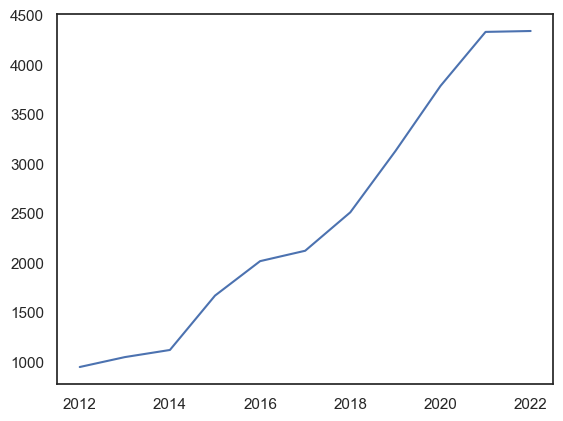

In [27]:
data['pub_year'].value_counts().sort_index().plot()

## Disciplines

In [28]:
data['static_data.fullrecord_metadata.category_info.subjects.subject'].isna().sum()

10

In [29]:
# Remove the records which have no values for the disciplines
data = data[~data['static_data.fullrecord_metadata.category_info.subjects.subject'].isna()]
data

UID                                    r_id_disclaimer  \
0      WOS:001024863300006  ResearcherID data provided by Clarivate Analytics   
1      WOS:001024100000002  ResearcherID data provided by Clarivate Analytics   
2      WOS:001014734700006  ResearcherID data provided by Clarivate Analytics   
3      WOS:001021623900035  ResearcherID data provided by Clarivate Analytics   
4      WOS:001022758800024  ResearcherID data provided by Clarivate Analytics   
...                    ...                                                ...   
28000  WOS:000327693800007  ResearcherID data provided by Clarivate Analytics   
28001  WOS:000209026700004  ResearcherID data provided by Clarivate Analytics   
28002  WOS:000298184700003  ResearcherID data provided by Clarivate Analytics   
28003  WOS:000297392700012  ResearcherID data provided by Clarivate Analytics   
28004  WOS:000301532000011  ResearcherID data provided by Clarivate Analytics   

      static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                                   OCT 2022                               23   
1                               JAN-MAR 2022                                1   
2                                       2022                               24   
3                                       2022                               51   
4                                       2022                               28   
...                                      ...                              ...   
28000                                   2012                             23.0   
28001                                   2012                             29.0   
28002                               JAN 2012                            639.0   
28003                               JAN 2012                             28.0   
28004                                   2012                             24.0   

      static_data.summary.pub_info.journal_oas_gold  \
0                                                 N   
1                                                 N   
2                                                 N   
3                                                 Y   
4                                                 Y   
...                                             ...   
28000                                             N   
28001                                             N   
28002                                             N   
28003                                             N   
28004                                             N   

       static_data.summary.pub_info.pubyear  \
0                                      2022   
1                                      2022   
2                                      2022   
3                                      2022   
4                                      2022   
...                                     ...   
28000                                  2012   
28001                                  2012   
28002                                  2012   
28003                                  2012   
28004                                  2012   

      static_data.summary.pub_info.issue  \
0                                      5   
1                                     57   
2                                      2   
3                                    NaN   
4                                    NaN   
...                                  ...   
28000                                  7   
28001                                  3   
28002                                NaN   
28003                                  1   
28004                                  2   

      static_data.summary.pub_info.sortdate  \
0                                2022-10-01   
1                                2022-01-01   
2                                2022-01-01   
3                                2022-01-01   
4                                2022-01-01   
...                                     

In [30]:
df_subjects = data['static_data.fullrecord_metadata.category_info.subjects.subject'].explode().reset_index(name='subjects')
df_subjects['temporary_index'] = df_subjects.index
df_subjects_temp = pd.json_normalize(df_subjects['subjects'])
df_subjects_temp['temporary_index'] = df_subjects_temp.index
df_subjects_temp['index'] = df_subjects_temp['temporary_index'].map(df_subjects.set_index('temporary_index')['index'])

df_subjects_temp

ascatype code                                      content  \
0      traditional   RZ                                      Nursing   
1         extended  NaN                                      Nursing   
2      traditional   HA             Education & Educational Research   
3         extended  NaN             Education & Educational Research   
4      traditional   HA             Education & Educational Research   
...            ...  ...                                          ...   
79975     extended  NaN              Health Care Sciences & Services   
79976     extended  NaN  Public, Environmental & Occupational Health   
79977     extended  NaN                                   Psychology   
79978     extended  NaN                           Respiratory System   
79979     extended  NaN                   Biomedical Social Sciences   

       temporary_index  index  
0                    0      0  
1                    1      0  
2                    2      1  
3                    3      1  
4                    4      2  
...                ...    ...  
79975            79975  28004  
79976            79976  28004  
79977            79977  28004  
79978            79978  28004  
79979            79979  28004  

[79980 rows x 5 columns]

In [31]:
df_subjects_temp_trad = df_subjects_temp[df_subjects_temp['ascatype'] == 'traditional']
df_subjects_temp_ext = df_subjects_temp[df_subjects_temp['ascatype'] == 'extended']

df_subjects_temp_trad = df_subjects_temp_trad.groupby(['index'], as_index=False).agg({'content': ', '.join})
df_subjects_temp_ext = df_subjects_temp_ext.groupby(['index'], as_index=False).agg({'content': ', '.join})

df_subjects_temp_trad = df_subjects_temp_trad.rename(columns={'content': 'tASCA discipline'})
df_subjects_temp_ext = df_subjects_temp_ext.rename(columns={'content': 'eASCA discipline'})

In [32]:
len(df_subjects_temp_trad), len(df_subjects_temp_ext)

(26978, 26978)

In [33]:
# Join them to the main dataframe

data = data.merge(df_subjects_temp_trad, on='index')
data = data.merge(df_subjects_temp_ext, on='index')

In [34]:

data

UID                                    r_id_disclaimer  \
0      WOS:001024863300006  ResearcherID data provided by Clarivate Analytics   
1      WOS:001024100000002  ResearcherID data provided by Clarivate Analytics   
2      WOS:001014734700006  ResearcherID data provided by Clarivate Analytics   
3      WOS:001021623900035  ResearcherID data provided by Clarivate Analytics   
4      WOS:001022758800024  ResearcherID data provided by Clarivate Analytics   
...                    ...                                                ...   
26973  WOS:000327693800007  ResearcherID data provided by Clarivate Analytics   
26974  WOS:000209026700004  ResearcherID data provided by Clarivate Analytics   
26975  WOS:000298184700003  ResearcherID data provided by Clarivate Analytics   
26976  WOS:000297392700012  ResearcherID data provided by Clarivate Analytics   
26977  WOS:000301532000011  ResearcherID data provided by Clarivate Analytics   

      static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                                   OCT 2022                               23   
1                               JAN-MAR 2022                                1   
2                                       2022                               24   
3                                       2022                               51   
4                                       2022                               28   
...                                      ...                              ...   
26973                                   2012                             23.0   
26974                                   2012                             29.0   
26975                               JAN 2012                            639.0   
26976                               JAN 2012                             28.0   
26977                                   2012                             24.0   

      static_data.summary.pub_info.journal_oas_gold  \
0                                                 N   
1                                                 N   
2                                                 N   
3                                                 Y   
4                                                 Y   
...                                             ...   
26973                                             N   
26974                                             N   
26975                                             N   
26976                                             N   
26977                                             N   

       static_data.summary.pub_info.pubyear  \
0                                      2022   
1                                      2022   
2                                      2022   
3                                      2022   
4                                      2022   
...                                     ...   
26973                                  2012   
26974                                  2012   
26975                                  2012   
26976                                  2012   
26977                                  2012   

      static_data.summary.pub_info.issue  \
0                                      5   
1                                     57   
2                                      2   
3                                    NaN   
4                                    NaN   
...                                  ...   
26973                                  7   
26974                                  3   
26975                                NaN   
26976                                  1   
26977                                  2   

      static_data.summary.pub_info.sortdate  \
0                                2022-10-01   
1                                2022-01-01   
2                                2022-01-01   
3                                2022-01-01   
4                                2022-01-01   
...                                     

In [35]:
test_subjects = df_subjects_temp[df_subjects_temp['ascatype'] == 'traditional']
discs = test_subjects['content'].unique().tolist()

with open(r'disciplines.txt', 'w') as fp:
    fp.write('\n'.join(discs))

In [36]:
comp_fields = ['Computer Science', 'Artificial Intelligence', 'Information Systems', 'Theory & Methods',
            'Engineering', 'Electrical & Electronic', 'Telecommunications', 'Software Engineering',
            'Green & Sustainable Science & Technology', 'Scientific Disciplines', 'Automation & Control Systems',
            'Cybernetics', 'Physics', 'Mathematical', 'Mathematics', 'Mathematical Methods']
soc_fields = ['Education & Educational Research', 'Literature', 'Urban Studies', 'History',
         'Communication', 'Political Science', 'Women\'s Studies', 'Social Sciences', 'International Relations',
         'History & Philosophy Of Science', 'Linguistics', 'Anthropology', 'Sociology', 'Social Work', 'Language & Linguistics',
         'Information Science', 'Psychology', 'Social', 'Ethnic Studies', 'Philosophy', 'Psychiatry']
mult_fields = ['Interdisciplinary', 'Multidisciplinary', 'Multidisciplinary Sciences', 'Behavioral Sciences', 
            'Interdisciplinary Applications']

In [37]:
data['Discipline'] = data['tASCA discipline'].apply(lambda x: 'Multidisciplinary' if (any(y in x for y in comp_fields) & any(y in x for y in soc_fields)) else '')
data['Discipline'] = np.where(((~data['tASCA discipline'].isin(comp_fields)) & (data['tASCA discipline'].isin(soc_fields))), 'Social Science', data['Discipline'])
data['Discipline'] = np.where(((data['tASCA discipline'].isin(comp_fields)) & (~data['tASCA discipline'].isin(soc_fields))), 'Computer Science', data['Discipline'])

data['Discipline'] = np.where(data['tASCA discipline'].isin(mult_fields), 'Multidisciplinary', data['Discipline'])

data['Discipline'].unique()

/var/folders/0j/1qy2cqc94ps2sn2sx3l2_0w80000gn/T/ipykernel_892/3840337471.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



array(['', 'Social Science', 'Multidisciplinary', 'Computer Science'],
      dtype=object)

In [38]:
data = data[~(data['Discipline'] == '')]
data = data.reset_index()
data

level_0                  UID  \
0           1  WOS:001024100000002   
1           2  WOS:001014734700006   
2           4  WOS:001022758800024   
3           5  WOS:001013292900013   
4           6  WOS:001013292900024   
...       ...                  ...   
6222    26951  WOS:000306548900102   
6223    26961  WOS:000302730200032   
6224    26964  WOS:000304489000090   
6225    26970  WOS:000380253702066   
6226    26972  WOS:000380252704067   

                                        r_id_disclaimer  \
0     ResearcherID data provided by Clarivate Analytics   
1     ResearcherID data provided by Clarivate Analytics   
2     ResearcherID data provided by Clarivate Analytics   
3     ResearcherID data provided by Clarivate Analytics   
4     ResearcherID data provided by Clarivate Analytics   
...                                                 ...   
6222  ResearcherID data provided by Clarivate Analytics   
6223  ResearcherID data provided by Clarivate Analytics   
6224  ResearcherID data provided by Clarivate Analytics   
6225  ResearcherID data provided by Clarivate Analytics   
6226  ResearcherID data provided by Clarivate Analytics   

     static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                              JAN-MAR 2022                                1   
1                                      2022                               24   
2                                      2022                               28   
3                                      2022                               14   
4                                      2022                               14   
...                                     ...                              ...   
6222                            JUL 18 2012                              7.0   
6223                             FEB 9 2012                              7.0   
6224                            MAR 28 2012                              7.0   
6225                                   2012                              NaN   
6226                                   2012                              NaN   

     static_data.summary.pub_info.journal_oas_gold  \
0                                                N   
1                                                N   
2                                                Y   
3                                                N   
4                                                N   
...                                            ...   
6222                                             Y   
6223                                             Y   
6224                                             Y   
6225                                             N   
6226                                             N   

      static_data.summary.pub_info.pubyear static_data.summary.pub_info.issue  \
0                                     2022                                 57   
1                                     2022                                  2   
2                                     2022                                NaN   
3                                     2022                                  3   
4                                     2022                                  3   
...                                    ...                                ...   
6222                                  2012                                  7   
6223                                  2012                                  2   
6224                                  2012                                  3   
6225                                  2012                                NaN   
6226                                  2012                                NaN   

     static_data.summary.pub_info.sortdate  \
0                               2022-01-01   
1                               2022-01-01   
2                               2022-01-01   
3                               2022-01-01   
4                          

In [39]:
data['Discipline'].value_counts()

Social Science       5155
Multidisciplinary    1049
Computer Science       23
Name: Discipline, dtype: int64

In [40]:
data['Discipline'] = data['Discipline'].replace({'Multidisciplinary': 'Computer Science'})
data['Discipline'].value_counts()

Social Science      5155
Computer Science    1072
Name: Discipline, dtype: int64

In [41]:
data = data.rename(columns = {'static_data.fullrecord_metadata.abstracts.abstract.abstract_text.p': 'abstract'})
data['abstract'] = data['abstract'].astype(str)
data

level_0                  UID  \
0           1  WOS:001024100000002   
1           2  WOS:001014734700006   
2           4  WOS:001022758800024   
3           5  WOS:001013292900013   
4           6  WOS:001013292900024   
...       ...                  ...   
6222    26951  WOS:000306548900102   
6223    26961  WOS:000302730200032   
6224    26964  WOS:000304489000090   
6225    26970  WOS:000380253702066   
6226    26972  WOS:000380252704067   

                                        r_id_disclaimer  \
0     ResearcherID data provided by Clarivate Analytics   
1     ResearcherID data provided by Clarivate Analytics   
2     ResearcherID data provided by Clarivate Analytics   
3     ResearcherID data provided by Clarivate Analytics   
4     ResearcherID data provided by Clarivate Analytics   
...                                                 ...   
6222  ResearcherID data provided by Clarivate Analytics   
6223  ResearcherID data provided by Clarivate Analytics   
6224  ResearcherID data provided by Clarivate Analytics   
6225  ResearcherID data provided by Clarivate Analytics   
6226  ResearcherID data provided by Clarivate Analytics   

     static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                              JAN-MAR 2022                                1   
1                                      2022                               24   
2                                      2022                               28   
3                                      2022                               14   
4                                      2022                               14   
...                                     ...                              ...   
6222                            JUL 18 2012                              7.0   
6223                             FEB 9 2012                              7.0   
6224                            MAR 28 2012                              7.0   
6225                                   2012                              NaN   
6226                                   2012                              NaN   

     static_data.summary.pub_info.journal_oas_gold  \
0                                                N   
1                                                N   
2                                                Y   
3                                                N   
4                                                N   
...                                            ...   
6222                                             Y   
6223                                             Y   
6224                                             Y   
6225                                             N   
6226                                             N   

      static_data.summary.pub_info.pubyear static_data.summary.pub_info.issue  \
0                                     2022                                 57   
1                                     2022                                  2   
2                                     2022                                NaN   
3                                     2022                                  3   
4                                     2022                                  3   
...                                    ...                                ...   
6222                                  2012                                  7   
6223                                  2012                                  2   
6224                                  2012                                  3   
6225                                  2012                                NaN   
6226                                  2012                                NaN   

     static_data.summary.pub_info.sortdate  \
0                               2022-01-01   
1                               2022-01-01   
2                               2022-01-01   
3                               2022-01-01   
4                          

In [42]:
df_authors = pd.DataFrame.from_dict(data['static_data.summary.names.name'].explode())
df_authors['index'] = df_authors.index
df_auth_temp = pd.json_normalize(df_authors['static_data.summary.names.name']).set_index(df_authors.index)
#df_auth_temp['temp_index'] = df_auth_temp.index

df_authors = pd.concat([df_authors, df_auth_temp], axis='columns')
df_authors = df_authors.drop(columns=['static_data.summary.names.name'])

df_authors['full_name'] = df_authors['full_name'].astype(str)
df_authors

index  seq_no       role                       full_name reprint  \
0         0     1.0     author       Santorun, Santiago Gallur       Y   
0         0     2.0     author           Arias, Jenerlis Arias     NaN   
1         1     1.0     author  Avila Rodriguez-de-Mier, Belen       Y   
1         1     2.0     author        Marin-Palacios, Cristina     NaN   
2         2     1.0     author                Tatsenko, Polina       Y   
...     ...     ...        ...                             ...     ...   
6225   6225     1.0     author              Pasek, Zbigniew J.       Y   
6225   6225     2.0  book_corp                            ASEE     NaN   
6226   6226     1.0     author           Pears, Arnold Neville       Y   
6226   6226     2.0     author                    Sheard, Judy     NaN   
6226   6226     3.0  book_corp                            ASEE     NaN   

     addr_no                last_name                    display_name  \
0          1                 Santorun       Santorun, Santiago Gallur   
0          2                    Arias           Arias, Jenerlis Arias   
1          1  Avila Rodriguez-de-Mier  Avila Rodriguez-de-Mier, Belen   
1          1           Marin-Palacios        Marin-Palacios, Cristina   
2          1                 Tatsenko                Tatsenko, Polina   
...      ...                      ...                             ...   
6225       1                    Pasek              Pasek, Zbigniew J.   
6225     NaN                      NaN                            ASEE   
6226       1                    Pears           Pears, Arnold Neville   
6226       1                   Sheard                    Sheard, Judy   
6226     NaN                      NaN                            ASEE   

               wos_standard       first_name  ...  \
0              Santorun, SG  Santiago Gallur  ...   
0                 Arias, JA   Jenerlis Arias  ...   
1     Rodriguez-de-Mier, BA            Belen  ...   
1         Marin-Palacios, C         Cristina  ...   
2               Tatsenko, P           Polina  ...   
...                     ...              ...  ...   
6225              Pasek, ZJ      Zbigniew J.  ...   
6225                    NaN              NaN  ...   
6226              Pears, AN   Arnold Neville  ...   
6226              Sheard, J             Judy  ...   
6226                    NaN              NaN  ...   

     data-item-ids.data-item-id.id-type  preferred_name.full_name  \
0                                   NaN                       NaN   
0                                   NaN                       NaN   
1                                   NaN                       NaN   
1                                   NaN                       NaN   
2                                   NaN                       NaN   
...                                 ...                       ...   
6225                       PreferredRID        Pasek, Zbigniew J.   
6225                                NaN                       NaN   
6226                       PreferredRID             Pears, Arnold   
6226                       PreferredRID              Sheard, Judy   
6226                                NaN                       NaN   

     preferred_name.last_name preferred_name.first_name noncore_endyear  \
0                         NaN                       NaN             NaN   
0                         NaN                       NaN             NaN   
1                         NaN                       NaN             NaN   
1                         NaN                       NaN             NaN   
2                         NaN                       NaN             NaN   
...                       ...                       ...             ...   
6225                    Pasek               Zbigniew J.             NaN   
6225                      NaN                       NaN             NaN   
6226                    Pears                    Arnold          2022.0   
6226                   S

In [43]:
authors = df_authors.groupby(['index'])['full_name'].apply('; '.join).reset_index().rename(columns={'full_name':'authors'})
authors['authors'] = authors['authors'].replace('nan', np.nan, regex=True)
authors

index                                            authors
0         0   Santorun, Santiago Gallur; Arias, Jenerlis Arias
1         1  Avila Rodriguez-de-Mier, Belen; Marin-Palacios...
2         2               Tatsenko, Polina; Tatsenko, Nataliia
3         3  Grubba, Leilane Serratine; de Oliveira, Julian...
4         4                                                NaN
...     ...                                                ...
6222   6222  Muesch, Kathrin; Engel, Andreas K.; Schneider,...
6223   6223                                                NaN
6224   6224  Rodondi, Nicolas; Locatelli, Isabella; Aujesky...
6225   6225                           Pasek, Zbigniew J.; ASEE
6226   6226          Pears, Arnold Neville; Sheard, Judy; ASEE

[6227 rows x 2 columns]

In [44]:
authors['authors'].iloc[4]

nan

In [45]:
authors['authors'].isna().sum()

2635

In [46]:
data = pd.merge(data, authors, on='index', how='left')
data

level_0                  UID  \
0           1  WOS:001024100000002   
1           2  WOS:001014734700006   
2           4  WOS:001022758800024   
3           5  WOS:001013292900013   
4           6  WOS:001013292900024   
...       ...                  ...   
6222    26951  WOS:000306548900102   
6223    26961  WOS:000302730200032   
6224    26964  WOS:000304489000090   
6225    26970  WOS:000380253702066   
6226    26972  WOS:000380252704067   

                                        r_id_disclaimer  \
0     ResearcherID data provided by Clarivate Analytics   
1     ResearcherID data provided by Clarivate Analytics   
2     ResearcherID data provided by Clarivate Analytics   
3     ResearcherID data provided by Clarivate Analytics   
4     ResearcherID data provided by Clarivate Analytics   
...                                                 ...   
6222  ResearcherID data provided by Clarivate Analytics   
6223  ResearcherID data provided by Clarivate Analytics   
6224  ResearcherID data provided by Clarivate Analytics   
6225  ResearcherID data provided by Clarivate Analytics   
6226  ResearcherID data provided by Clarivate Analytics   

     static_data.summary.pub_info.coverdate static_data.summary.pub_info.vol  \
0                              JAN-MAR 2022                                1   
1                                      2022                               24   
2                                      2022                               28   
3                                      2022                               14   
4                                      2022                               14   
...                                     ...                              ...   
6222                            JUL 18 2012                              7.0   
6223                             FEB 9 2012                              7.0   
6224                            MAR 28 2012                              7.0   
6225                                   2012                              NaN   
6226                                   2012                              NaN   

     static_data.summary.pub_info.journal_oas_gold  \
0                                                N   
1                                                N   
2                                                Y   
3                                                N   
4                                                N   
...                                            ...   
6222                                             Y   
6223                                             Y   
6224                                             Y   
6225                                             N   
6226                                             N   

      static_data.summary.pub_info.pubyear static_data.summary.pub_info.issue  \
0                                     2022                                 57   
1                                     2022                                  2   
2                                     2022                                NaN   
3                                     2022                                  3   
4                                     2022                                  3   
...                                    ...                                ...   
6222                                  2012                                  7   
6223                                  2012                                  2   
6224                                  2012                                  3   
6225                                  2012                                NaN   
6226                                  2012                                NaN   

     static_data.summary.pub_info.sortdate  \
0                               2022-01-01   
1                               2022-01-01   
2                               2022-01-01   
3                               2022-01-01   
4                          

In [47]:
abstract_df = data[['index', 'abstract', 'Discipline', 'title', 'pub_year', 'authors']]
abstract_df = abstract_df.drop_duplicates(subset=['abstract', 'Discipline', 'title'])
len(abstract_df)

5638

In [48]:
abstract_df['abstract'] = abstract_df['abstract'].replace('nan', np.nan, regex=True)
abstract_df = abstract_df[~abstract_df['abstract'].isna()]
len(abstract_df)

4676

In [49]:
abstract_df['Discipline'].value_counts()

Social Science      3964
Computer Science     712
Name: Discipline, dtype: int64

In [50]:
df_cs = abstract_df[abstract_df['Discipline'] == 'Computer Science']
df_ss = abstract_df[abstract_df['Discipline'] == 'Social Science']

### Social Science

In [51]:
# Create representation models
keybert_model = KeyBERTInspired(top_n_words=50, nr_repr_docs= 40, random_state=1234)
mmr_model = MaximalMarginalRelevance(diversity=0.3)
pos_patterns = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}]
]
# DEFAULT_PATTERNS = [ [{'POS': 'ADJ'}, {'POS': 'NOUN'}], [{'POS': 'NOUN'}], [{'POS': 'ADJ'}] ]
pos_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_patterns) 

representation_models = [pos_model, keybert_model, mmr_model]

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

#word_model = api.load('fasttext-wiki-news-subwords-300')
sentence_model = SentenceTransformer("all-mpnet-base-v2") # all-MiniLM-L6-v2
#word_doc_embedder = WordDocEmbedder(embedding_model=sentence_model, word_embedding_model=word_model)
embeddings_ss = sentence_model.encode(df_ss['abstract'].astype(str).to_list(), show_progress_bar=True)

Batches:   0%|          | 0/124 [00:00<?, ?it/s]

In [52]:
umap_model = umap.UMAP(n_neighbors=50, n_components=80, min_dist=0.0, metric='cosine', random_state=1234)
#vectorizer_model = CountVectorizer(stop_words="english")
vectorizer_model = TfidfVectorizer()
cluster_model = KMeans(n_clusters=20)

#reduced_embeddings_comp = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_comp)

topic_model_ss = BERTopic(
    language='english', # Set to 'multilingual' for datasets with languages other than English. # a few other languages set so changing from 'english'
    top_n_words=30,
    n_gram_range=(1, 3),
    #min_topic_size=10,
    nr_topics= 'auto',
    low_memory=False,
    calculate_probabilities=True, # The probabilities of all topics per document.
    representation_model=representation_models,
    embedding_model=sentence_model,
    hdbscan_model= cluster_model, 
    umap_model=umap_model, 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model
)

In [53]:
topics_ss, probs_ss = topic_model_ss.fit_transform(df_ss['abstract'].astype('str').to_list(), embeddings_ss)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [54]:
topic_model_ss.get_topic_info()

Topic  Count                                            Name  \
0       0   1553              0_feminist_sexism_violence_victims   
1       1    439       1_feminism_masculinity_sexuality_cultural   
2       2    316    2_partisanship_candidates_politics_electoral   
3       3    270        3_patriarchal_feminist_misogyny_literary   
4       4    267        4_victims_distress_psychosocial_refugees   
5       5    237         5_feminism_cyberviolence_media_hashtags   
6       6    223    6_discrimination_academics_gendered_academia   
7       7    192             7_stem_education_stereotypes_gender   
8       8    144         8_linguistic_pronouns_stereotypes_nouns   
9       9    122    9_journalistic_journalism_sexism_journalists   
10     10    118  10_sexualization_portrayals_stereotypes_gender   
11     11     83         11_discrimination_lgbtq_cisgender_lgbti   

                                       Representation  \
0   [feminist, sexism, violence, victims, educatio...   
1   [feminism, masculinity, sexuality, cultural, s...   
2   [partisanship, candidates, politics, electoral...   
3   [patriarchal, feminist, misogyny, literary, hi...   
4   [victims, distress, psychosocial, refugees, he...   
5   [feminism, cyberviolence, media, hashtags, blo...   
6   [discrimination, academics, gendered, academia...   
7   [stem, education, stereotypes, gender, subject...   
8   [linguistic, pronouns, stereotypes, nouns, eng...   
9   [journalistic, journalism, sexism, journalists...   
10  [sexualization, portrayals, stereotypes, gende...   
11  [discrimination, lgbtq, cisgender, lgbti, nond...   

                                  Representative_Docs  
0   [In recent years, in many Spanish universities...  
1   [The article deals with the environmental ideo...  
2   [When presented the choice between a male and ...  
3   [Purpose. To study the phenomenon of a woman-a...  
4   [The COVID-19 pandemic has led to lasting ment...  
5   [In order to explain the popularity of Instagr...  
6   [['Background: College reentry women are often...  
7   [['When we make the decision of choosing an ac...  
8   [['The aim of the research was to analyze the ...  
9   [Gender inequalities in public relations (PR) ...  
10  [The article analyzes the ways people talk abo...  
11  [['Background: Same sex attracted women (SSAW)...

In [59]:
topic_model_ss.visualize_barchart(topics=None, top_n_topics=20, n_words=10, custom_labels=True, width=350, height=350)

In [65]:
topics_change_ss = {0: 'Feminism with misogyny/sexism', 1: 'Sexism in sports', 2: 'Sexism in politics', 
                      3: 'Misogyny in patriarchy', 4: 'Psychosocial impacts due to sexism',
                      5: 'Sexism in cyberspace', 6: 'Gender discrimination in academia',
                      7: 'Gender stereotype in STEM', 8: 'Linguistics of sexism', 9: 'Sexism in journalism/media', 10: 'Sexism in gaming', 
                      11: 'Sexism and queer studies'}

topic_model_ss.set_topic_labels(topics_change_ss)

In [67]:
topic_model_ss.visualize_documents(df_ss['abstract'].to_list(), custom_labels=True, width=800, height=550) 

In [55]:
# Create representation models
keybert_model = KeyBERTInspired(top_n_words=50, nr_repr_docs= 10, random_state=1234)
mmr_model = MaximalMarginalRelevance(diversity=0.3)
pos_patterns = [
            [{'POS': 'ADJ'}, {'POS': 'NOUN'}],
            [{'POS': 'NOUN'}], [{'POS': 'ADJ'}]
]
# DEFAULT_PATTERNS = [ [{'POS': 'ADJ'}, {'POS': 'NOUN'}], [{'POS': 'NOUN'}], [{'POS': 'ADJ'}] ]
pos_model = PartOfSpeech("en_core_web_sm", pos_patterns=pos_patterns) 

representation_models = [pos_model, keybert_model, mmr_model]

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

#word_model = api.load('fasttext-wiki-news-subwords-300')
sentence_model = SentenceTransformer("all-mpnet-base-v2") # all-MiniLM-L6-v2
#word_doc_embedder = WordDocEmbedder(embedding_model=sentence_model, word_embedding_model=word_model)
embeddings_cs = sentence_model.encode(df_cs['abstract'].astype(str).to_list(), show_progress_bar=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [56]:
umap_model = umap.UMAP(n_neighbors=50, n_components=80, min_dist=0.0, metric='cosine', random_state=1234)
#vectorizer_model = CountVectorizer(stop_words="english")
vectorizer_model = TfidfVectorizer()
cluster_model = KMeans(n_clusters=15)

#reduced_embeddings_comp = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_comp)

topic_model_cs = BERTopic(
    language='english', # Set to 'multilingual' for datasets with languages other than English. # a few other languages set so changing from 'english'
    top_n_words=30,
    n_gram_range=(1, 3),
    #min_topic_size=10,
    nr_topics= 'auto',
    low_memory=False,
    calculate_probabilities=True, # The probabilities of all topics per document.
    representation_model=representation_models,
    embedding_model=sentence_model,
    hdbscan_model= cluster_model, 
    umap_model=umap_model, 
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model
)

In [57]:
topics_cs, probs_cs = topic_model_cs.fit_transform(df_cs['abstract'].astype('str').to_list(), embeddings_cs)

In [58]:
topics_comp = pd.DataFrame(topic_model_cs.get_topic_info())
topics_comp

Topic  Count                                             Name  \
0      0    266            0_stereotypes_stem_gendered_education   
1      1    209      1_victimization_healthcare_prevalence_women   
2      2     88      2_diabetes_hypertension_patients_predictors   
3      3     49                3_corpus_debiasing_sentiment_text   
4      4     34                    4_faces_stimuli_emotional_eeg   
5      5     28  5_osteoarthritis_gait_musculoskeletal_fractures   
6      6     22               6_svm_biometrics_convolutional_rnn   
7      7     16        7_discrimination_health_ethnicity_poverty   

                                      Representation  \
0  [stereotypes, stem, gendered, education, teach...   
1  [victimization, healthcare, prevalence, women,...   
2  [diabetes, hypertension, patients, predictors,...   
3  [corpus, debiasing, sentiment, text, racism, e...   
4  [faces, stimuli, emotional, eeg, brain, schizo...   
5  [osteoarthritis, gait, musculoskeletal, fractu...   
6  [svm, biometrics, convolutional, rnn, voice, f...   
7  [discrimination, health, ethnicity, poverty, m...   

                                 Representative_Docs  
0  [Background Despite the diverse student popula...  
1  [['Background', 'The incidence of child labour...  
2  [['Objectives', 'Despite recommendations that ...  
3  [Author profiling is the identification of dem...  
4  [According to the Scalar Expectancy Theory, hu...  
5  [['Background', "Most studies of smartphone-ba...  
6  [Recently, there have been many studies on the...  
7  [['Background: There is mounting evidence that...

In [60]:
topic_model_cs.visualize_barchart(topics=None, top_n_topics=20, n_words=10, custom_labels=True, width=350, height=350)

In [68]:
topics_change_cs = {0: 'Gender stereotype in STEM', 1: 'Sexism in healthcare', 2: 'Sexism in healthcare', 
                      3: 'Language bias in sexism studies', 4: 'Miscellaneous', 5: 'Medical studies',
                      6: 'Neural networks in healthcare studies', 7: 'Health discrimination with ethnicity'}

topic_model_cs.set_topic_labels(topics_change_cs)

In [69]:
topic_model_cs.visualize_documents(df_cs['abstract'].to_list(), custom_labels=True, width=750, height=500) 